In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

# Experiment ----------------------

In [ ]:
# download from here https://github.com/BioWar/Satellite-Image-Segmentation-using-Deep-Learning-for-Deforestation-Detection
!cp -r /content/drive/MyDrive/deff /content/diff

In [ ]:
import torch
import torchvision
import numpy as np
from torch import amp
import torch.nn as nn
from tqdm import tqdm
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.utils import make_grid
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import losses
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
!rm -r runs

In [ ]:
writer = SummaryWriter('/content/runs/unet')

In [ ]:
!cp -r /content/drive/MyDrive/tmpp /content/tmpp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
i = glob("diff/images/*.png")
m = glob("diff/masks/*.png")

def normalize(arr, a, b):
    one_per = np.percentile(arr, 1)
    nine_per = np.percentile(arr, 99)
    return ((arr-one_per) * ((b-a)/(nine_per-one_per))+a)

def replace_colors(image, red_tolerance=50):
    rep_img = np.zeros_like(image)

    mi = np.array([255 - red_tolerance, 0, 0])
    ma = np.array([255, red_tolerance, red_tolerance])

    red_mask = np.all((image >= mi) & (image <= ma), axis=-1)

    rep_img[red_mask] = [255, 255, 255]

    rep_img = rep_img[:, :, 0].astype(np.uint8)

    rep_img[rep_img == 255] = 1

    return rep_img

i.sort()
m.sort()

a = zip(i, m)

def make_it(x):
    for i, a in enumerate(x):
        img = np.asarray(Image.open(a[0]))
        msk = np.asarray(Image.open(a[1]))

        img = normalize(np.transpose(img, (2, 0, 1)), 0, 1)
        msk = replace_colors(msk)

        with open(f'tmpp/images/{i}.npy', 'wb') as f:
            np.save(f, img)
        with open(f'tmpp/masks/{i}.npy', 'wb') as f:
            np.save(f, msk)
# make_it(a)

In [ ]:
class DataGenerator(Dataset):
    def __init__(self, imgs, msks):
        self.image_files = imgs
        self.mask_files = msks

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img = np.load(self.image_files[index]).astype(np.float32)
        msk = np.load(self.mask_files[index]).astype(np.float32)

        img = torch.from_numpy(img)
        msk = torch.from_numpy(msk).unsqueeze(0)

        img, msk = self.transform(img, msk)

        return img, msk

    def transform(self, img, msk):
        a = np.random.rand()

        if a<0.2:
            hf = T.RandomHorizontalFlip(p=1.0)
            img = hf(img)
            msk = hf(msk)
        if a>0.2 and a<0.4:
            vf = T.RandomVerticalFlip(p=1.0)
            img = vf(img)
            msk = vf(msk)
        return np.array(img), np.array(msk)



In [ ]:
from random import shuffle

im_te = glob('tmpp/images/*.npy')
ms_te = glob('tmpp/masks/*.npy')

datas = list(zip(im_te, ms_te))
shuffle(datas)

imgs, msks = zip(*datas)

idx = int(len(datas)*0.798)

train_images = imgs[:idx]
train_masks = msks[:idx]

val_images = imgs[idx:]
val_masks = msks[idx:]
#
print(len(train_images))
print(len(val_images))

256
66


In [ ]:
train = DataLoader(DataGenerator(train_images, train_masks), batch_size=8, shuffle=True, pin_memory=True, num_workers=4)
val = DataLoader(DataGenerator(val_images, val_masks), batch_size=8, shuffle=True, pin_memory=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
next(iter(train))[1][:4].squeeze(dim=1).shape

torch.Size([4, 512, 512])

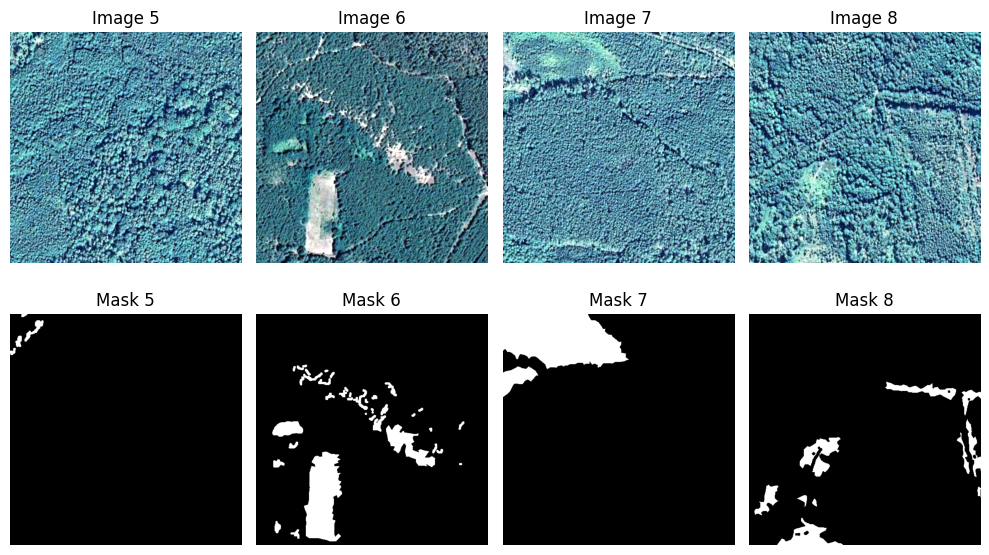

In [ ]:
images, masks = next(iter(train))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
fig, axes = plt.subplots(2, 4, figsize=(10, 6))

for i in range(8):
    ax = axes[0, i%4]
    ax.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.axis('off')
    ax.set_title(f'Image {i+1}')

    ax = axes[1, i%4]
    ax.imshow(np.squeeze(masks[i]), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Mask {i+1}')

plt.tight_layout()
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = smp.Unet(encoder_name="efficientnet-b6", encoder_weights="imagenet", in_channels=3, classes=1, activation = None).to(device)

model = smp.PSPNet(encoder_name="efficientnet-b6", encoder_weights="imagenet", in_channels=3, classes=1, activation = None).to(device)

# model = smp.DeepLabV3Plus(encoder_name="efficientnet-b6", encoder_weights="imagenet", in_channels=3, classes=1, activation = None).to(device)

In [ ]:
class IOU(nn.Module):

    def __init__(self, weight=None, size_average=True):
        super(IOU, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_losss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):

        BCE = self.bce_losss(inputs, targets)

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(
            inputs.sum() + targets.sum() + smooth)
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Wed Dec 11 15:13:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              34W /  70W |    535MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
epoch = 50

early_stopper = EarlyStopper(patience=3, min_delta=0.01)

t_losses = []
t_acc = []

t_val_losses = []
t_acc_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

criterion = DiceBCELoss().to(device)

iou = IOU()

t_losses = []
t_acc = []

t_val_losses = []
t_acc_losses = []

im = next(iter(train))[0][:4].to(device)
writer.add_graph(model, im)

del im

torch.cuda.empty_cache()

for epo in range(1, epoch+1):
    model.train()

    train_losses = []
    train_acc = []

    for i, x in enumerate(tqdm(train)):
        img = x[0].to(device)
        msk = x[1].to(device)

        optimizer.zero_grad(set_to_none=True)

        with amp.autocast(device.type):
            out = model(img)

            loss = criterion(out, msk)

            loss.backward()

            optimizer.step()

            acc = iou(out, msk)

        train_losses.append(loss.item())
        train_acc.append(acc.item())

    print(f'Train epoch: {epo} loss: {np.mean(train_losses):.4f} iou: {np.mean(train_acc):.4f}')

    t_losses.append(np.mean(train_losses))
    t_acc.append(np.mean(train_acc))

    model.eval()

    val_losses = []
    val_acc = []

    for i, x in enumerate(tqdm(val)):
        img = x[0].to(device)
        msk = x[1].to(device)

        with torch.no_grad():
            out = model(img)
            loss = criterion(out, msk)

            acc = iou(out, msk)

        val_losses.append(loss.item())
        val_acc.append(acc.item())

    print(f'Validation epoch: {epo} loss: {np.mean(val_losses):.4f} iou: {np.mean(val_acc):.4f}')

    t_val_losses.append(np.mean(val_losses))
    t_acc_losses.append(np.mean(val_acc))

    if epo%5==1:

        x = img.cpu()[:4]
        y = msk.cpu()[:4].squeeze(dim=1)
        z = out[:4]

        z = torch.sigmoid(z)
        z = (z > 0.5).float()
        z = z.cpu().squeeze(dim=1)

        x = make_grid(x, nrow=4, normalize=False, padding=5)
        y = make_grid(y, nrow=4, normalize=False, padding=5)
        z = make_grid(z, nrow=4, normalize=False, padding=5)

        writer.add_image("Input image", x, global_step=epo)
        writer.add_image("Mask", y, global_step=epo)
        writer.add_image("Predicted mask", z, global_step=epo)

    if early_stopper.early_stop(np.mean(val_losses)):
        print(f'Early stopping at epoch {epo}')

        x = img.cpu()[:4]
        y = msk.cpu()[:4].squeeze(dim=1)
        z = out[:4]

        z = torch.sigmoid(z)
        z = (z > 0.5).float()
        z = z.cpu().squeeze(dim=1)

        x = make_grid(x, normalize=False)
        y = make_grid(y, normalize=False)
        z = make_grid(z, normalize=False)

        writer.add_image("Input image", x, global_step=epo)
        writer.add_image("Mask", y, global_step=epo)
        writer.add_image("Predicted mask", z, global_step=epo)

        writer.add_scalars("Loss", {
            'train': np.mean(train_losses),
            'val': np.mean(val_losses)
        }, global_step=epo)

        writer.add_scalars("Accuracy", {
            'train': np.mean(train_acc),
            'val': np.mean(val_acc)
        }, global_step=epo)

        break

    writer.add_scalars("Loss", {
        'train': np.mean(train_losses),
        'val': np.mean(val_losses)
    }, global_step=epo)

    writer.add_scalars("Accuracy", {
        'train': np.mean(train_acc),
        'val': np.mean(val_acc)
    }, global_step=epo)


    writer.flush()
    writer.close()


    if early_stopper.early_stop(np.mean(val_losses)):
        print(f'Early stopping at epoch {epo}')
        checkpoint = {
            'epoch': epo,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            't_loss': t_losses,
            't_acc': t_acc,
            'v_loss': t_val_losses,
            'v_acc': t_acc_losses
        }

        torch.save(checkpoint, 'model_checkpoint.pth')
        !cp model_checkpoint.pth /content/drive/MyDrive/test.pth
        break

    elif epo%10 == 0:
        checkpoint = {
            'epoch': epo,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            't_loss': t_losses,
            't_acc': t_acc,
            'v_loss': t_val_losses,
            'v_acc': t_acc_losses
        }

        torch.save(checkpoint, 'model_checkpoint.pth')
        !cp model_checkpoint.pth /content/drive/MyDrive/test.pth


/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/model.py:17: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:
100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Train epoch: 1 loss: 1.2143 iou: 0.0937


100%|██████████| 9/9 [00:02<00:00,  4.29it/s]


Validation epoch: 1 loss: 1.1155 iou: 0.1315


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Train epoch: 2 loss: 0.8636 iou: 0.2405


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Validation epoch: 2 loss: 0.8803 iou: 0.2354


100%|██████████| 32/32 [00:12<00:00,  2.56it/s]


Train epoch: 3 loss: 0.6890 iou: 0.3460


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Validation epoch: 3 loss: 0.7124 iou: 0.3530


100%|██████████| 32/32 [00:12<00:00,  2.55it/s]


Train epoch: 4 loss: 0.5891 iou: 0.4266


100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


Validation epoch: 4 loss: 0.6656 iou: 0.3976


100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


Train epoch: 5 loss: 0.5266 iou: 0.4732


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Validation epoch: 5 loss: 0.5511 iou: 0.4938


100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


Train epoch: 6 loss: 0.5374 iou: 0.4755


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


Validation epoch: 6 loss: 0.5413 iou: 0.4867


100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


Train epoch: 7 loss: 0.4779 iou: 0.5158


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Validation epoch: 7 loss: 0.4970 iou: 0.5328


100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


Train epoch: 8 loss: 0.4595 iou: 0.5337


100%|██████████| 9/9 [00:02<00:00,  3.80it/s]


Validation epoch: 8 loss: 0.4883 iou: 0.5189


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Train epoch: 9 loss: 0.4271 iou: 0.5600


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


Validation epoch: 9 loss: 0.5434 iou: 0.4923


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Train epoch: 10 loss: 0.4172 iou: 0.5644


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Validation epoch: 10 loss: 0.4489 iou: 0.5727


100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Train epoch: 11 loss: 0.3886 iou: 0.5888


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Validation epoch: 11 loss: 0.4666 iou: 0.5657


100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Train epoch: 12 loss: 0.4111 iou: 0.5697


100%|██████████| 9/9 [00:02<00:00,  4.17it/s]


Validation epoch: 12 loss: 0.4427 iou: 0.5751


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Train epoch: 13 loss: 0.4453 iou: 0.5556


100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


Validation epoch: 13 loss: 0.4289 iou: 0.5796


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Train epoch: 14 loss: 0.3684 iou: 0.6101


100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


Validation epoch: 14 loss: 0.4067 iou: 0.6040


100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Train epoch: 15 loss: 0.3710 iou: 0.6044


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Validation epoch: 15 loss: 0.4137 iou: 0.6150


100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


Train epoch: 16 loss: 0.3810 iou: 0.6035


100%|██████████| 9/9 [00:02<00:00,  3.36it/s]


Validation epoch: 16 loss: 0.4759 iou: 0.5505


100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Train epoch: 17 loss: 0.3840 iou: 0.6002


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Validation epoch: 17 loss: 0.4083 iou: 0.5971


100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Train epoch: 18 loss: 0.3555 iou: 0.6178


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Validation epoch: 18 loss: 0.4191 iou: 0.6028


100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Train epoch: 19 loss: 0.3415 iou: 0.6317


100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


Validation epoch: 19 loss: 0.3845 iou: 0.6150


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Train epoch: 20 loss: 0.3260 iou: 0.6461


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Validation epoch: 20 loss: 0.3895 iou: 0.6094


100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


Train epoch: 21 loss: 0.3485 iou: 0.6382


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Validation epoch: 21 loss: 0.4951 iou: 0.5537


100%|██████████| 32/32 [00:12<00:00,  2.46it/s]


Train epoch: 22 loss: 0.3353 iou: 0.6408


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Validation epoch: 22 loss: 0.3939 iou: 0.6054


100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Train epoch: 23 loss: 0.2992 iou: 0.6689


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Validation epoch: 23 loss: 0.3685 iou: 0.6509


100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Train epoch: 24 loss: 0.3238 iou: 0.6510


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Validation epoch: 24 loss: 0.4435 iou: 0.5793


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Train epoch: 25 loss: 0.3125 iou: 0.6611


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Validation epoch: 25 loss: 0.4092 iou: 0.6076


100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


Train epoch: 26 loss: 0.3205 iou: 0.6488


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Validation epoch: 26 loss: 0.3866 iou: 0.6331
Early stopping at epoch 26


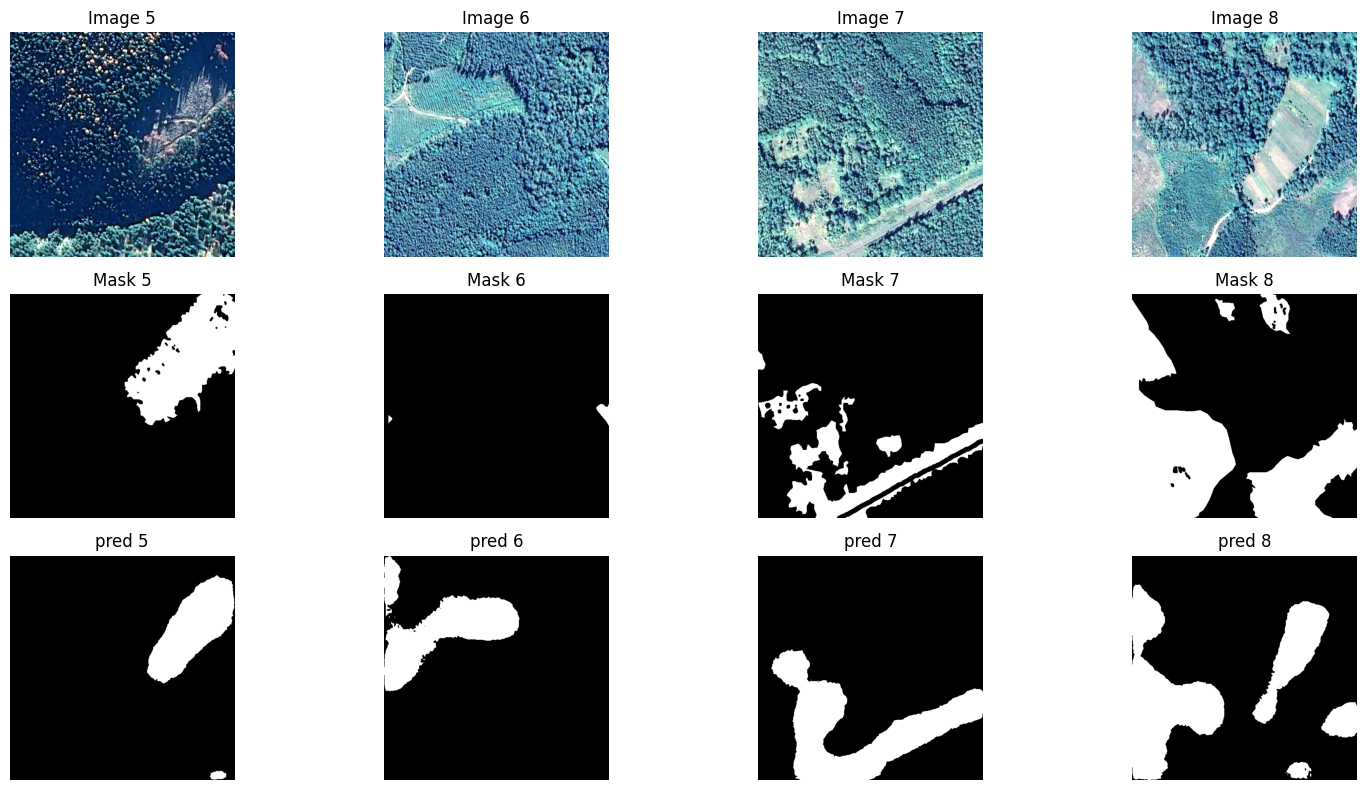

In [ ]:
model.eval()

from itertools import islice

x = next(islice(val, 3, None))

# x = next(iter(train))

with torch.no_grad():
    out = model(x[0].to(device))

# out = out.cpu().numpy()

out = torch.sigmoid(out)
out = (out > 0.5).float()
out = out.cpu().numpy()

images, masks = next(islice(train, 9, None))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
fig, axes = plt.subplots(3, 4, figsize=(16, 8))

for i in range(8):
    ax = axes[0, i%4]
    ax.imshow(np.transpose(x[0][i], (1, 2, 0)))
    ax.axis('off')
    ax.set_title(f'Image {i+1}')

    ax = axes[1, i%4]
    ax.imshow(np.squeeze(x[1][i]), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Mask {i+1}')

    ax = axes[2, i%4]
    ax.imshow(np.squeeze(out[i]), cmap='gray')
    ax.axis('off')
    ax.set_title(f'pred {i+1}')

plt.tight_layout()
plt.show()

# Experiment ends ------------

In [ ]:
!cp /content/drive/MyDrive/deep.pth deep.pth
!cp /content/drive/MyDrive/unet.pth unet.pth
!cp /content/drive/MyDrive/psp.pth psp.pth

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_details(pth, model):
    mdl = torch.load(pth, map_location=device)
    model.load_state_dict(mdl['model_state_dict'])
    t_loss = mdl.get('t_loss', None)
    t_acc = mdl.get('t_acc', None)
    v_acc = mdl.get('v_acc', None)
    v_loss = mdl.get('v_loss', None)
    return model, t_loss, t_acc, v_acc, v_loss

def plot_loss(t_loss, v_loss):
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(t_loss, label='training')
    plt.plot(v_loss, label='validation')
    plt.legend()
    # plt.title(nam)
    plt.show()

def plot_acc(t_acc, v_acc):
    plt.plot(t_acc, label='training')
    plt.plot(v_acc, label='validation')
    plt.legend()
    # plt.title(nam)
    plt.show()

def predict(mdl, dat):
    # mdl.eval()

    with torch.no_grad():
        out = mdl(dat.to(device))

    out = torch.sigmoid(out)
    out = (out > 0.5).float()
    out = out.cpu().numpy()

    return out

def plot_images(dat, pred):
    fig, axes = plt.subplots(3, 4, figsize=(10, 6))

    for i in range(8):
        ax = axes[0, i%4]
        ax.imshow(np.transpose(dat[0][i], (1, 2, 0)))
        ax.axis('off')
        ax.set_title(f'Image {i+1}')

        ax = axes[1, i%4]
        ax.imshow(np.squeeze(dat[1][i]), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Mask {i+1}')

        ax = axes[2, i%4]
        ax.imshow(np.squeeze(pred[i]), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Prediction {i+1}')

    plt.tight_layout()
    plt.show()

In [ ]:
model = smp.DeepLabV3Plus(encoder_name="efficientnet-b6", encoder_weights="imagenet", in_channels=3, classes=1, activation = None).to(device)
deep, d_t_loss, d_t_acc, d_v_acc, d_v_loss = get_details('deep.pth', model)

model = smp.Unet(encoder_name="efficientnet-b6", encoder_weights="imagenet", in_channels=3, classes=1, activation = None).to(device)
unet, u_t_loss, u_t_acc, u_v_acc, u_v_loss = get_details('unet.pth', model)

model = smp.PSPNet(encoder_name="efficientnet-b6", encoder_weights="imagenet", in_channels=3, classes=1, activation = None).to(device)
psp, p_t_loss, p_t_acc, p_v_acc, p_v_loss = get_details('psp.pth', model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth
100%|██████████| 165M/165M [00:04<00:00, 37.9MB/s]
<ipython-input-7-a91598501a47>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case

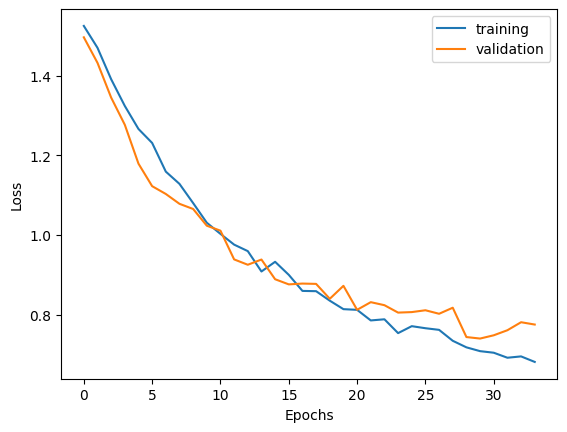

In [ ]:
plot_loss(d_t_loss, d_v_loss)

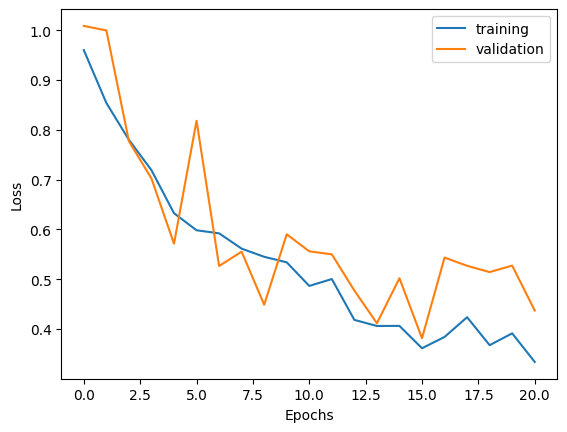

In [ ]:
plot_loss(u_t_loss, u_v_loss)

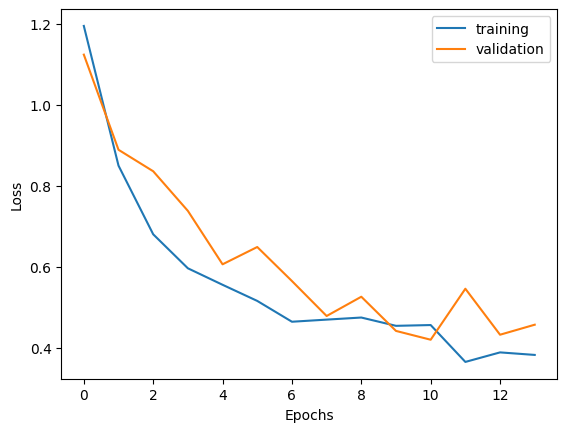

In [ ]:
plot_loss(p_t_loss, p_v_loss)

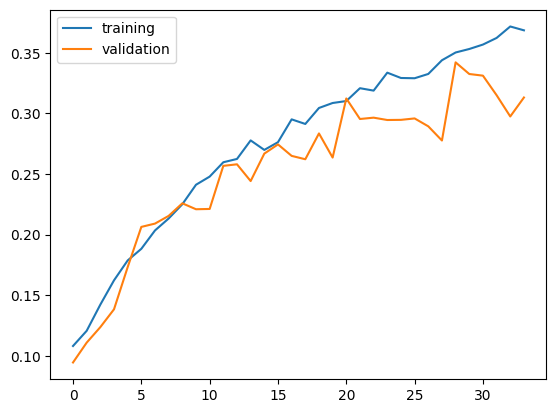

In [ ]:
plot_acc(d_t_acc, d_v_acc)

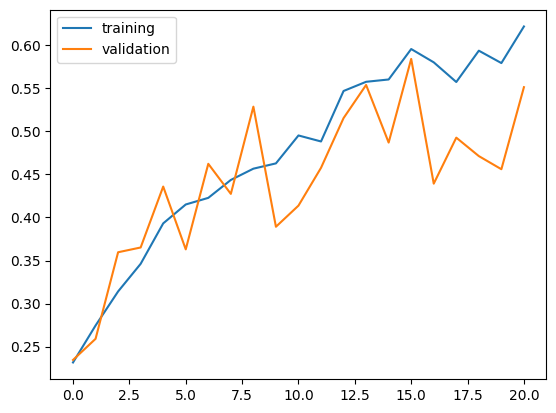

In [ ]:
plot_acc(u_t_acc, u_v_acc)

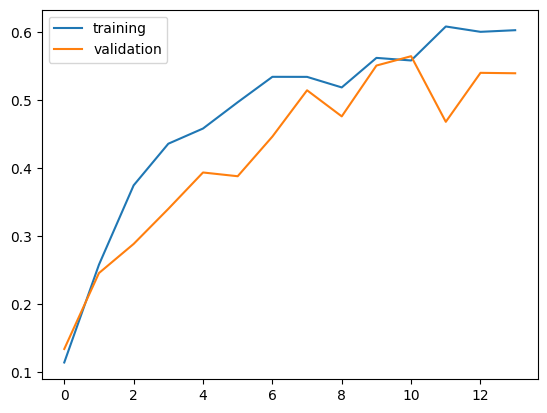

In [ ]:
plot_acc(p_t_acc, p_v_acc)

In [ ]:
from itertools import islice

dat = next(islice(val, 5, None))

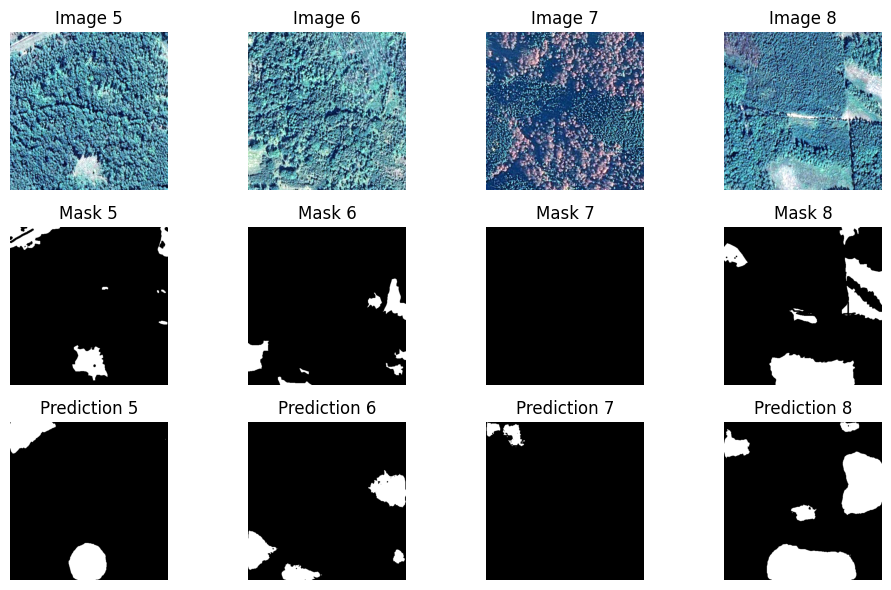

In [ ]:
pred = predict(deep, dat[0])
plot_images(dat, pred)

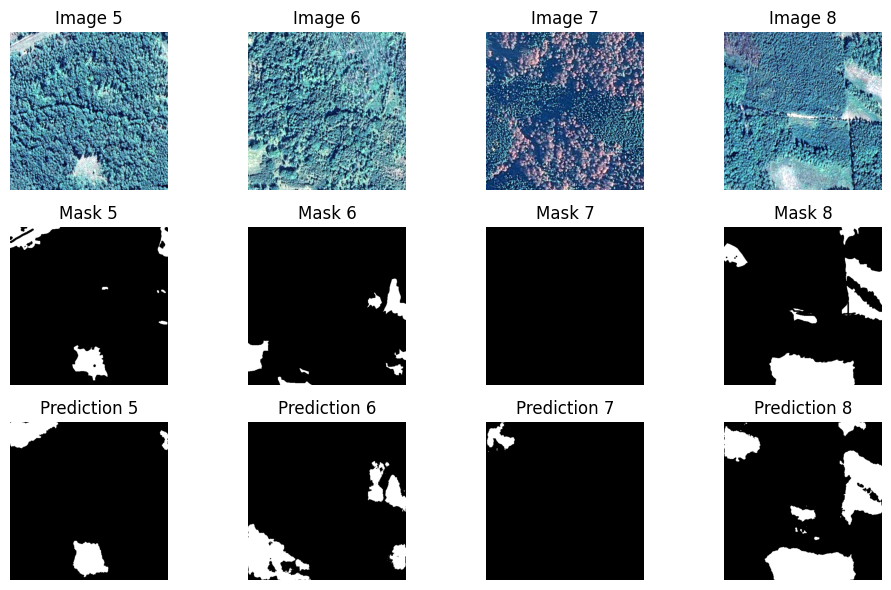

In [ ]:
pred = predict(unet, dat[0])
plot_images(dat, pred)

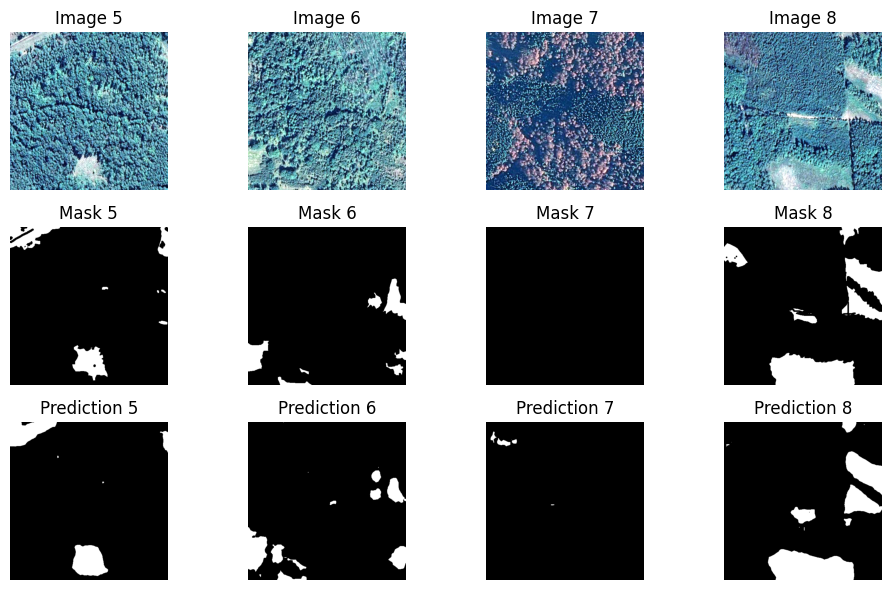

In [ ]:
model = smp.PSPNet(encoder_name="efficientnet-b6", encoder_weights="imagenet", in_channels=3, classes=1, activation = None).to(device)
pred = predict(psp, dat[0])
plot_images(dat, pred)

In [ ]:
print(d_v_acc[-1])
print(u_v_acc[-1])
print(p_v_acc[-1])

0.3130799281385003
0.5515182216962179
0.5398553510506948


In [ ]:
print(d_t_acc[-1])
print(u_t_acc[-1])
print(p_t_acc[-1])

0.36851987335830927
0.6220711857983561
0.6031622952132514


In [ ]:
# checkpoint = torch.load('model_checkpoint.pth', map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# t_losses = checkpoint.get('loss', None)
# t_iou = checkpoint.get('iou', None)
# model.to(device)